In [1]:
import numpy as np
import pandas as pd
import random
from scipy.stats import zscore
import os
import matplotlib.pyplot as plt
from scipy.stats import ranksums
working_dir = "/Users/nkarisan/PycharmProjects/BTC_Cell_Line_Atlas_Manuscript"
os.chdir(working_dir)

import scripts.io_library as io_library
io_library.input_dir = 'input_data/'
io_library.output_dir = 'Figure5/output_fig5/'

from scripts.io_library import MyLib
from scripts.clustering_utils import Clustering
from scripts.visualization import MyVisualization
from scripts.utils import Utils
from scripts.invoking_R_functions import MyRFunctions

In [2]:
import matplotlib
seed = 2023
random.seed(seed)
np.random.seed(seed)

matplotlib.use("nbagg")


%matplotlib inline
%config InlineBackend.figure_format = "retina"


%load_ext autoreload
%autoreload 2

## Load the data

In [3]:
rna_all_file = 'Main_Data/RNA/rna_cell_lines.csv'
upset_file = 'cell_lines_master_upset_2025-2-24.csv'

expr_df = MyLib.load_csv(rna_all_file)
expr_df.set_index('Gene', drop=True, inplace=True)
expr_df = expr_df.T # samples are the rows

raw_upset_df = MyLib.load_csv(upset_file)
raw_upset_df.set_index('Cell_line', inplace=True, drop=True)
upset_df = raw_upset_df[raw_upset_df['RNA']==1]
upset_df = upset_df[["Subtype"]]#,"RNA_Subtype"
upset_df = upset_df.loc[expr_df.index, :]
expr_df.shape

input_data/Main_Data/RNA/rna_cell_lines.csv  is loaded, shape:  (17649, 80)

input_data/cell_lines_master_upset_2025-2-24.csv  is loaded, shape:  (87, 12)



(79, 17649)

In [4]:
fold_expr_df = expr_df.apply(lambda x:x-x.median())

In [5]:
dorothea_res_df = MyRFunctions.dorothea_transcription_factors(fold_expr_df.T)

R[write to console]: Loading required package: usethis



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: data.table 1.14.8 using 1 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: **********
This installation of data.table has not detected OpenMP support. It should still work but in single-threaded mode.
This is a Mac. Please read https://mac.r-project.org/openmp/. Please engage with Apple and ask them for support. Check r-datatable.com for updates, and our Mac instructions here: https://github.com/Rdatatable/data.table/wiki/Installation. After several years of many reports of installation problems on Mac, it's time to gingerly point out that there have been no similar problems on Windows or Linux.
**********

R[write to console]: 
Attaching package: ‘data.table’


R[write to console]: The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


R[write to console]: The following objects are masked from ‘package:dplyr’:

    between, first, last


R[wri

In [6]:
dorothea_res_df

,statistic,source,condition,score,p_value
0,viper,ADNP,CCLP1,-1.341922,0.179621
1,viper,ADNP,CCSW1,0.082033,0.934620
2,viper,ADNP,AOVC1,0.128461,0.897785
3,viper,ADNP,ECC3,-0.689160,0.490723
4,viper,ADNP,EGI1,0.275038,0.783287
...,...,...,...,...,...
21720,viper,ZZZ3,TFK1,-1.515370,0.129679
21721,viper,ZZZ3,TGBC1TKB,0.542246,0.587649
21722,viper,ZZZ3,TGBC52TKB,-0.977494,0.328325
21723,viper,ZZZ3,TKKK,1.102545,0.270225


In [7]:
dorothea_mat_df = Utils.prepare_dorothea_results(dorothea_res_df)
MyLib.save_csv(dorothea_mat_df, 'dorothea_mat_zscore.csv')


File  Figure5/output_fig5/dorothea_res.csv saved, shape: (21725, 7)

File  Figure5/output_fig5/dorothea_mat_zscore.csv saved, shape: (275, 79)


In [8]:
RNA_upset_file = 'Figure5/output_fig5/RNA_Gene_reordered_upset_df.csv'
RNA_upset_df = pd.read_csv(RNA_upset_file, index_col=0)

In [9]:
dorothea_mat_df = dorothea_mat_df[RNA_upset_df.index]

# Clustering

In [10]:
dorothea_mat_df.shape

(275, 79)

In [11]:
tf_keys_df = pd.DataFrame(index=sorted(set(dorothea_res_df['source'].values)))

In [12]:
corr_df = pd.DataFrame(np.corrcoef(dorothea_mat_df.values), columns=dorothea_mat_df.index, index=dorothea_mat_df.index)
corr_df.shape

(275, 275)


File  Figure5/output_fig5/Transcription Factor_RNA_Cluster_reordered_upset_df.csv saved, shape: (275, 1)


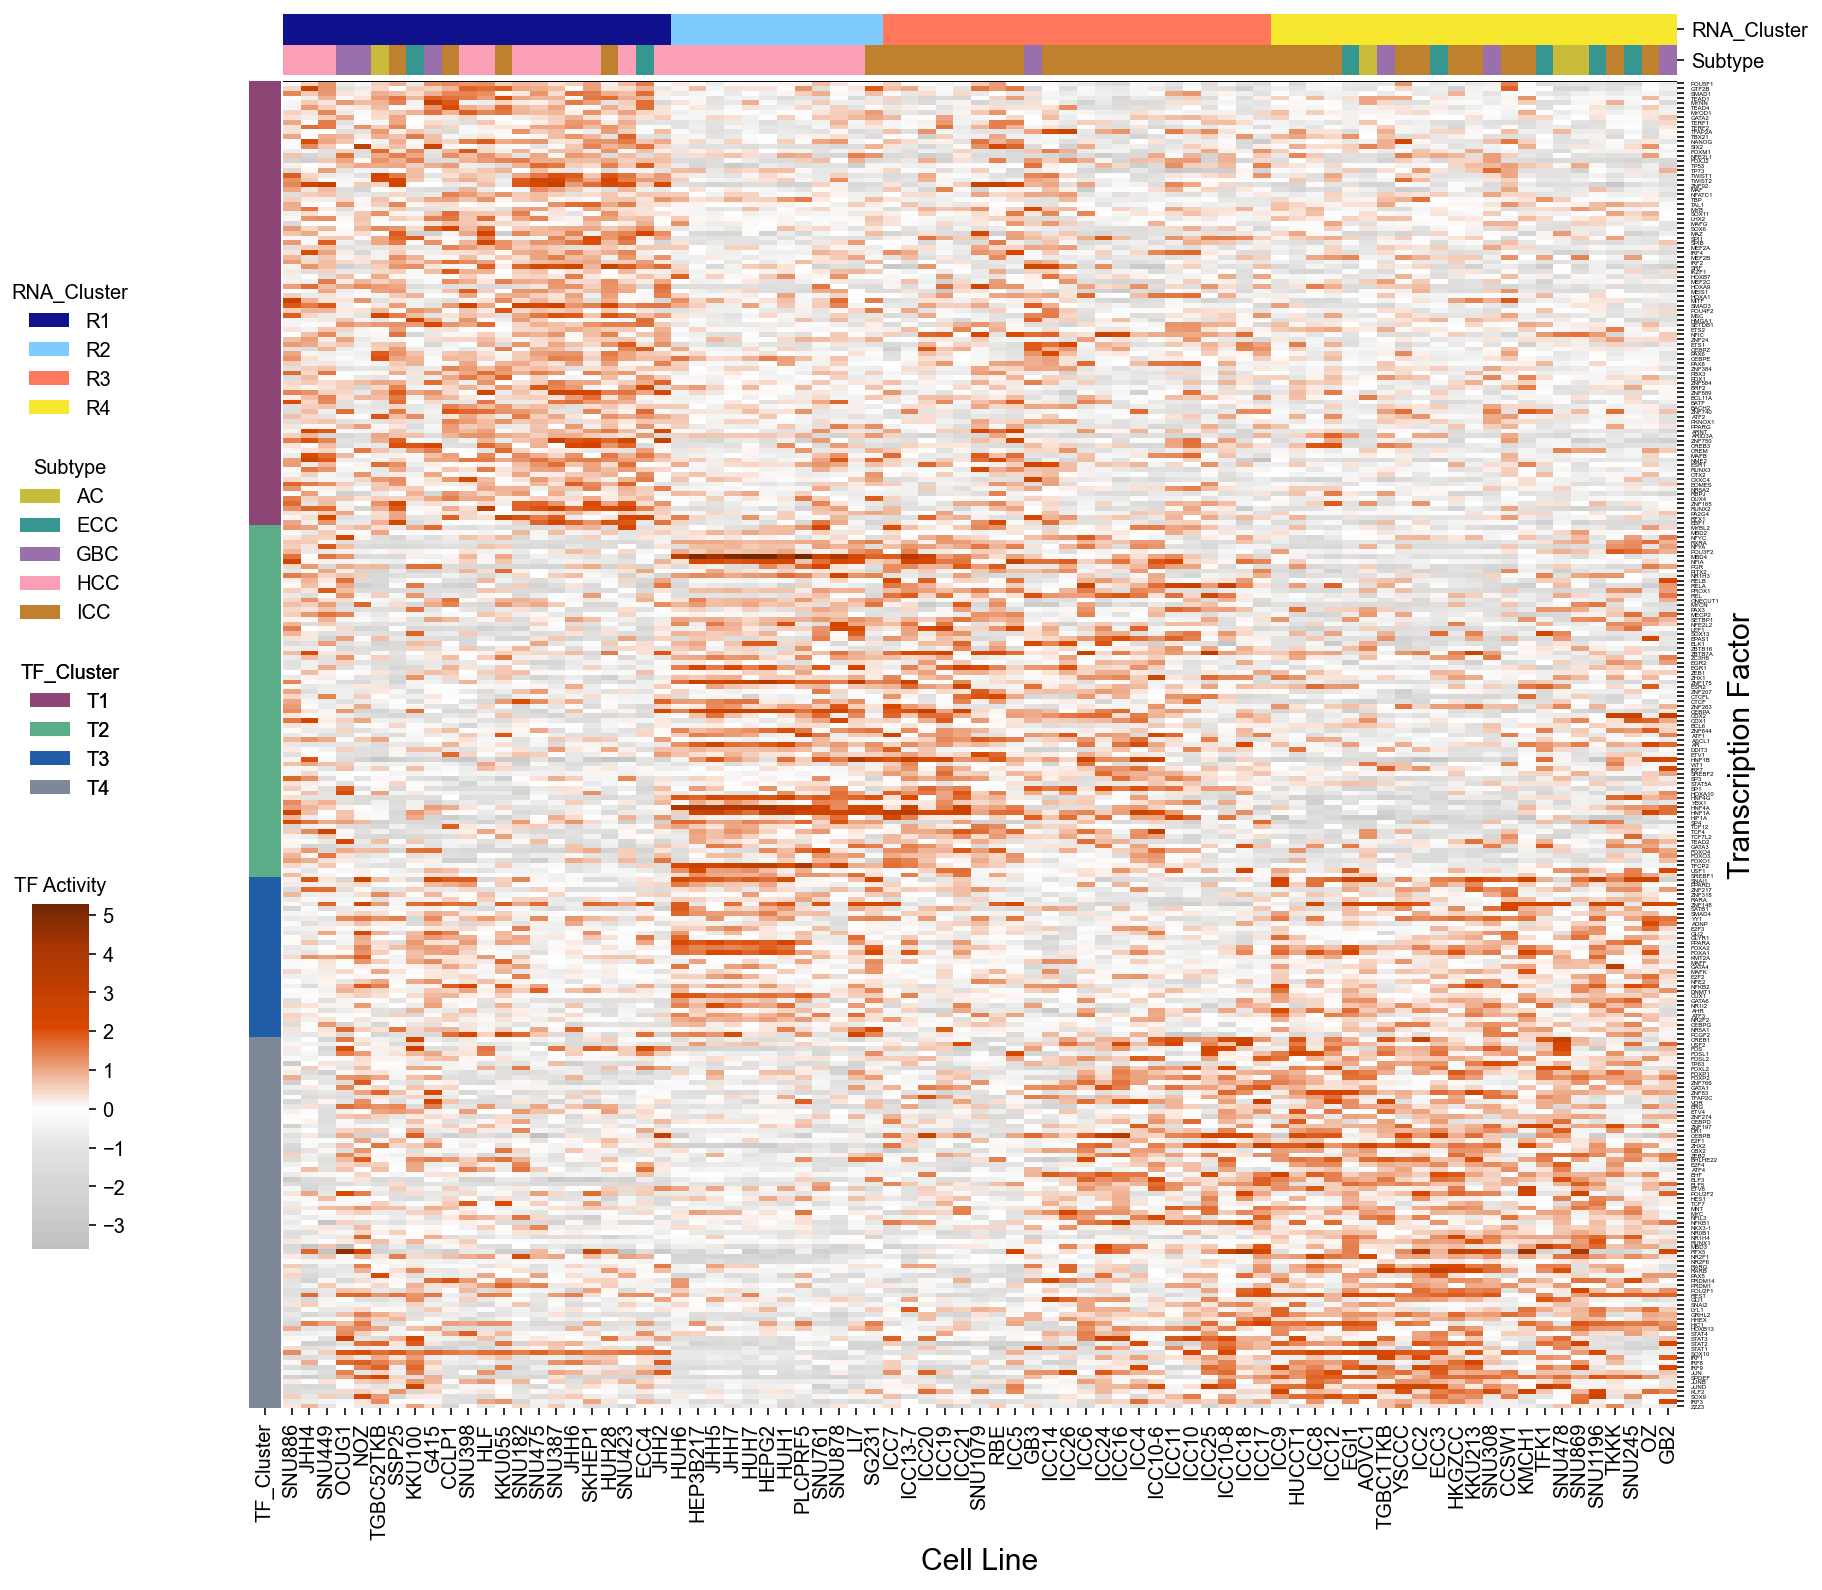

In [13]:
gammas = [1, 1.5, 2, 2.5, 3, 3.5]
labels_np, _ = Clustering.louvain_clustering_ensemble(corr_df, gammas=gammas)#ite=200,

clusters_reordering = [3, 2, 1, 4]#
Clustering.plot_TF_heatmap(data_df=dorothea_mat_df.copy(), labels_np=labels_np, col_upset_df=RNA_upset_df, clusters_reordering=clusters_reordering, col_name_cluster='RNA_Cluster',  row_upset_df=tf_keys_df, filter=True, cbar_title='TF Activity', row_label='Transcription Factor', col_label='Cell Line', event_legend = False, yticklabels=True, ytick_fontsize=3, xtick_fontsize=10, cbar_discrete=True, cbar_left_adjust=0.04, left_adjust=0.07, legend_top_offset=0.7, volcano_force_text=0.9, plot_volcano=False, borders_linewidths=0,
                           save_figure=True)

# HNF1B TF

In [14]:
hnf1b_TF_upset_df = pd.concat([RNA_upset_df, dorothea_mat_df.T['HNF1B']], axis=1)

In [15]:
res_df = Utils.ranksums_test_all_pairs(hnf1b_TF_upset_df[['HNF1B']], RNA_upset_df, data_col='HNF1B', cluster_col='RNA_Cluster')
res_df


----Pairwise Ranksums test----



,RNA_Cluster_1,RNA_Cluster_2,p-value,q-value,Status
0,R1,R3,0.000003,0.000018,significant
1,R1,R2,0.000034,0.000102,significant
2,R3,R4,0.000235,0.000470,significant
3,R2,R4,0.000660,0.000990,significant
4,R1,R4,0.211732,0.254078,ns
5,R2,R3,0.745683,0.745683,ns


In [16]:
pairs = [('R1', 'R2'), ('R1', 'R3'), ('R2', 'R3'), ('R3', 'R4')]
qvals = []
for pair in pairs:
    qvals.append(res_df[(res_df['RNA_Cluster_1']==pair[0]) & (res_df['RNA_Cluster_2']==pair[1])]['q-value'].values[0])
qvals

[0.00010225048521186883,
 1.797960745050852e-05,
 0.7456825420836933,
 0.000469520108127066]

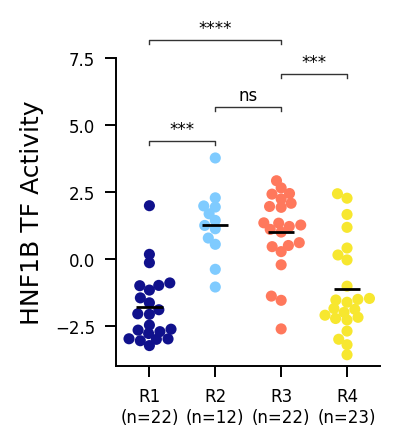

In [17]:
color_dic = MyVisualization.feat_colors_dic['RNA_Cluster']
MyVisualization.swarm_plot(hnf1b_TF_upset_df[['HNF1B','RNA_Cluster']], y_col='HNF1B', x_col='RNA_Cluster', hue_col='RNA_Cluster', palette_dic=color_dic, y_label='HNF1B TF Activity', x_label='', p_value=qvals,  sig_threshold=0.1, pvalue_pairs=pairs, star_pval=True, title_height=1.02, ylim_top=7.5, ylim_bottom=-4., ytick_step=2.5, figure_width=1.7, figure_height=2., label_newline=True, save_figure=True)

# CHOL in R3 vs R4

In [18]:
chol_upset_df = RNA_upset_df[RNA_upset_df['Subtype'].isin(['ICC', 'ECC']) & (RNA_upset_df['RNA_Cluster'].isin(['R3', 'R4']))]
chol_upset_df

,RNA_Cluster,Subtype
ICC7,R3,ICC
ICC13-7,R3,ICC
ICC20,R3,ICC
ICC19,R3,ICC
ICC21,R3,ICC
SNU1079,R3,ICC
RBE,R3,ICC
ICC5,R3,ICC
ICC14,R3,ICC
ICC26,R3,ICC


In [19]:
R3_cell_lines_l = chol_upset_df[chol_upset_df['RNA_Cluster']=='R3'].index.tolist()
R4_cell_lines_l = chol_upset_df[chol_upset_df['RNA_Cluster']=='R4'].index.tolist()
TF_R3_df = dorothea_mat_df[R3_cell_lines_l].T
TF_R4_df = dorothea_mat_df[R4_cell_lines_l].T
print('TF R3 shape:', TF_R3_df.shape)
print('TF R4 shape:', TF_R4_df.shape)

TF R3 shape: (21, 275)
TF R4 shape: (17, 275)


In [20]:
title= 'R3 vs R4 (TF Activity)'
down_df, up_df = Utils.statistical_test_and_volcano_plot(TF_R3_df, TF_R4_df, force_points=4, title=title, test='ranksum', xlim_right=1, ylim_top=5, force_text=.5, xlabel='Effect size', up_color='#077f97', down_color='#a00000', alpha_top=0.7, return_sig=True, plot_volcano=False)

In [21]:
down_df.set_index('feature', drop=True, inplace=True)
up_df.set_index('feature', drop=True, inplace=True)

In [22]:
down_df['R3_mRNA_mean'] = expr_df.loc[R3_cell_lines_l, down_df.index].mean()
down_df['R4_mRNA_mean'] = expr_df.loc[R4_cell_lines_l, down_df.index].mean()
up_df['R3_mRNA_mean'] = expr_df.loc[R3_cell_lines_l, up_df.index].mean()
up_df['R4_mRNA_mean'] = expr_df.loc[R4_cell_lines_l, up_df.index].mean()

    Keep only expressed TFs

In [23]:
down_df = down_df[down_df['R4_mRNA_mean']>1]
up_df = up_df[up_df['R3_mRNA_mean']>1]

In [24]:
MyLib.save_csv(down_df, f'{title}_down.csv')
MyLib.save_csv(up_df, f'{title}_up.csv')


File  Figure5/output_fig5/R3 vs R4 (TF Activity)_down.csv saved, shape: (53, 8)

File  Figure5/output_fig5/R3 vs R4 (TF Activity)_up.csv saved, shape: (48, 8)
